In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
%matplotlib inline

import olac.maths as mf
import olac.utils as uf
import olac.vis as vf

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style("white")
plt.rcParams["figure.figsize"] = (20, 10)
sns.set_palette(sns.color_palette("hls", 10))

# Dynamicity metrics - LAC
Define a set of metrics that capture the level of Dynamicity, i.e. indicate how dynamic fraud is.

Secondary it would be good if we can predict the direction of the fraud.

## Shorlist
- first, second moment
- volatility
- distribution fit:
    - KL divergence
    - KS test
- Linear regression
    - $R^2$
    - Mean Square Error
    - ...

## Data
https://datamarket.com/data/set/237v/daily-foreign-exchange-rates-31-december-1979-31-december-1998#!ds=237v!2jx6&display=line

In [4]:
df = pd.read_csv('../data/raw/LAC_daily-foreign-exchange-rates-31-.csv').dropna()
df['Date'] = pd.to_datetime(df['Date'])
df['Australia/US'] = df['Australia/US'].astype(np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4774 entries, 0 to 4773
Data columns (total 9 columns):
Date            4774 non-null datetime64[ns]
Australia/US    4774 non-null float64
British/US      4774 non-null float64
Canadian/US     4774 non-null float64
Dutch/US        4774 non-null float64
French/US       4774 non-null float64
German/US       4774 non-null float64
Japanese/US     4774 non-null float64
Swiss/US        4774 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 373.0 KB


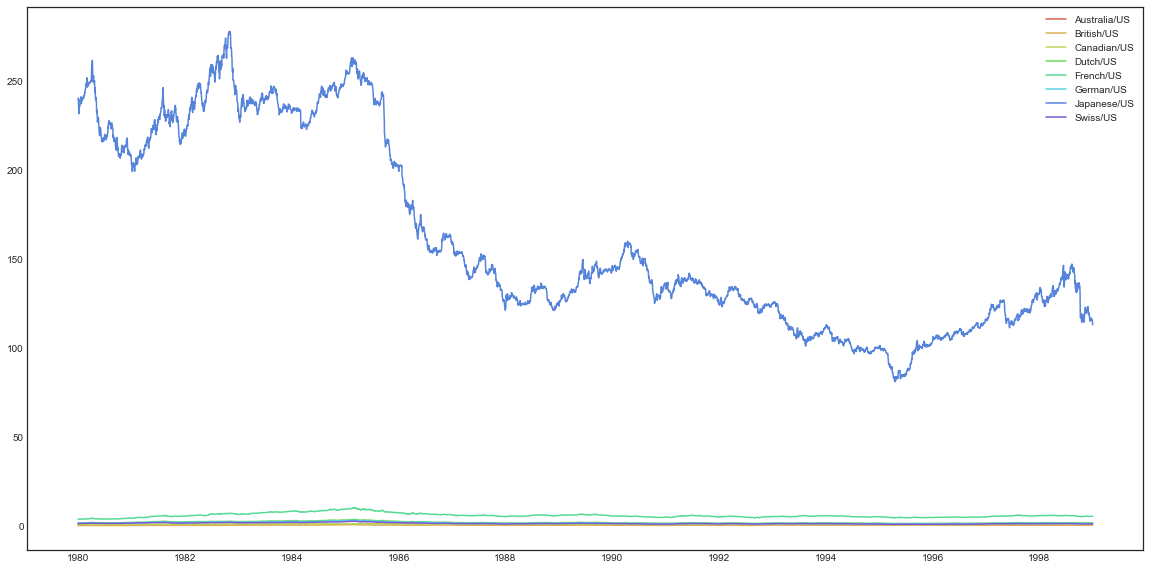

In [5]:
for col in df.iloc[:, 1:].columns:
    plt.plot(df['Date'], df[col], label=col)
plt.legend()

### Normalise the data

In [6]:
for col in df.iloc[:, 1:].columns:
    std_dev = df[col].std()
    mean = df[col].mean()
    df.loc[:, col] = (df[col] - mean) / std_dev

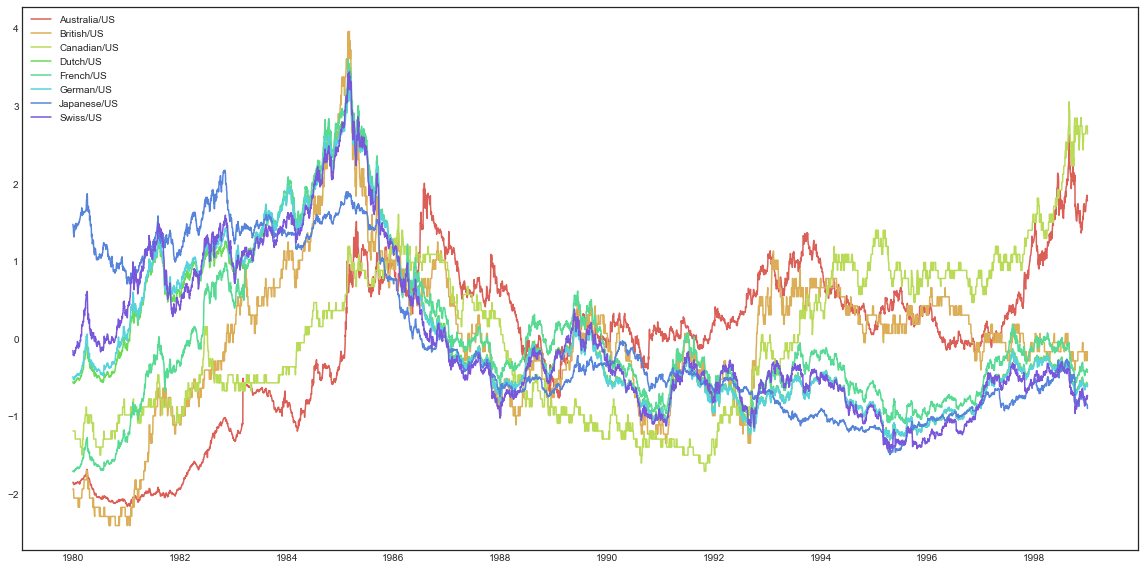

In [7]:
for col in df.iloc[:, 1:].columns:
    plt.plot(df['Date'], df[col], label=col)
plt.legend()

### Summary statistics

In [8]:
df.iloc[:, 1:].describe()

,Australia/US,British/US,Canadian/US,Dutch/US,French/US,German/US,Japanese/US,Swiss/US
count,4.774000e+03,4.774000e+03,4.774000e+03,4.774000e+03,4.774000e+03,4.774000e+03,4.774000e+03,4.774000e+03
mean,3.333925e-16,-8.334812e-17,-9.406431e-16,1.428825e-16,2.381375e-16,2.857650e-16,5.239025e-16,-4.286475e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.159685e+00,-2.405291e+00,-1.704287e+00,-1.304001e+00,-1.711525e+00,-1.299615e+00,-1.492631e+00,-1.439761e+00
25%,-5.328243e-01,-5.193188e-01,-8.769261e-01,-6.706074e-01,-6.317753e-01,-6.827351e-01,-7.375164e-01,-6.599325e-01
50%,1.587157e-01,7.004742e-02,-4.956539e-02,-3.617791e-01,-2.358940e-01,-3.643808e-01,-4.224466e-01,-3.671595e-01
75%,6.413012e-01,5.415404e-01,8.812154e-01,6.433883e-01,3.003304e-01,6.848665e-01,1.119060e+00,6.615934e-01
max,2.621394e+00,3.959864e+00,3.053037e+00,3.409074e+00,3.602856e+00,3.318174e+00,2.171857e+00,3.438889e+00


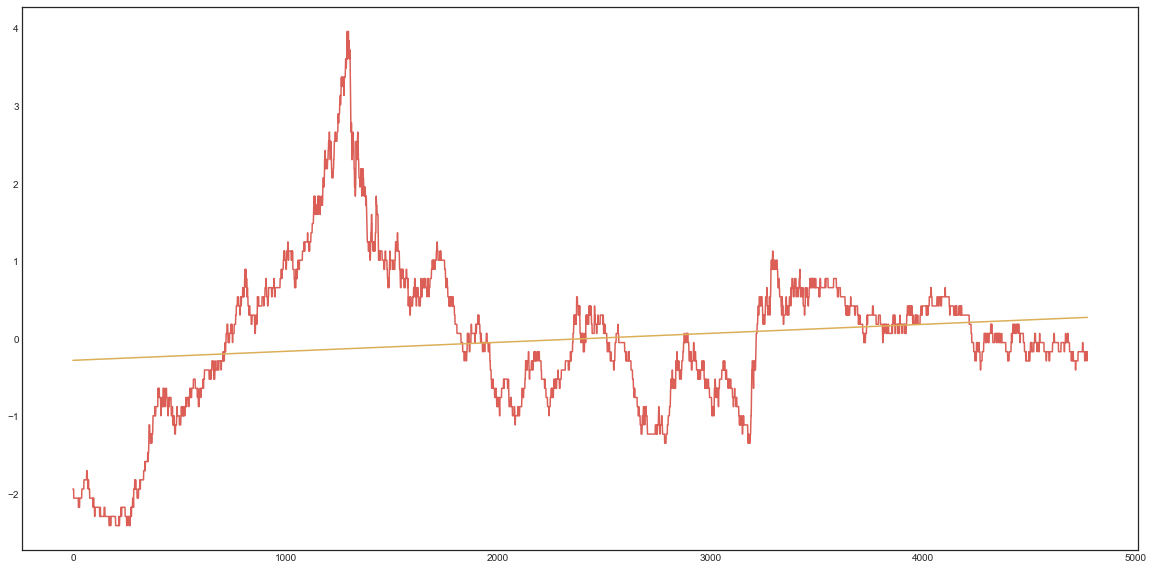

In [9]:
plt.plot(df.index.values, df['British/US'])
x = df.index.values[:, None]
alpha, beta = mf.linear_ls(x, df['British/US'].values)
plt.plot(x, (alpha + beta * x))

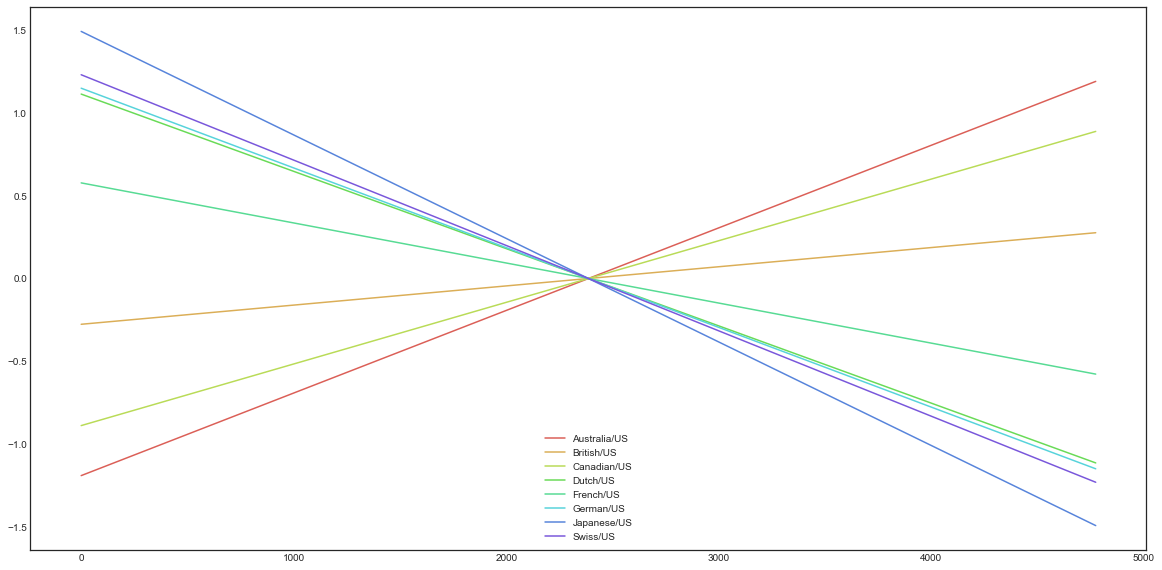

In [10]:
x = df.index.values[:, None]
for col in df.iloc[:, 1:].columns:
    alpha, beta = mf.linear_ls(x, df[col].values)
    plt.plot(x, (alpha + beta * x), label=col)
plt.legend()

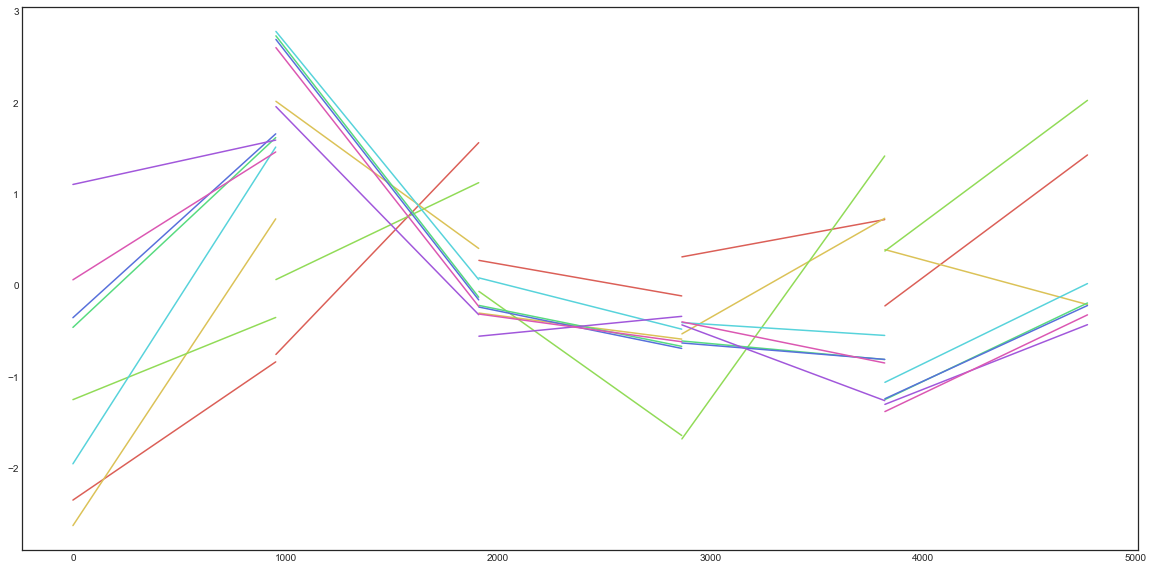

In [11]:
i = 0
for col in df.columns.values[1:]:
    for period in np.array_split(df.index.values, 5):
        y = df.loc[period, col].values
        alpha, beta = mf.linear_ls(period, y)
        plt.plot(period[:, None], (alpha + beta * period[:, None]), c=sns.color_palette("hls", 8)[i], label=("Period {0}, country {1}".format(period, col)))
    i += 1

In [12]:
x = df.index.values[:, None]
%timeit coefs, ind = mf.seq_linear_ls(x, df['British/US'].values, window_size=100)

1.34 ms ± 15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
x.size

4774

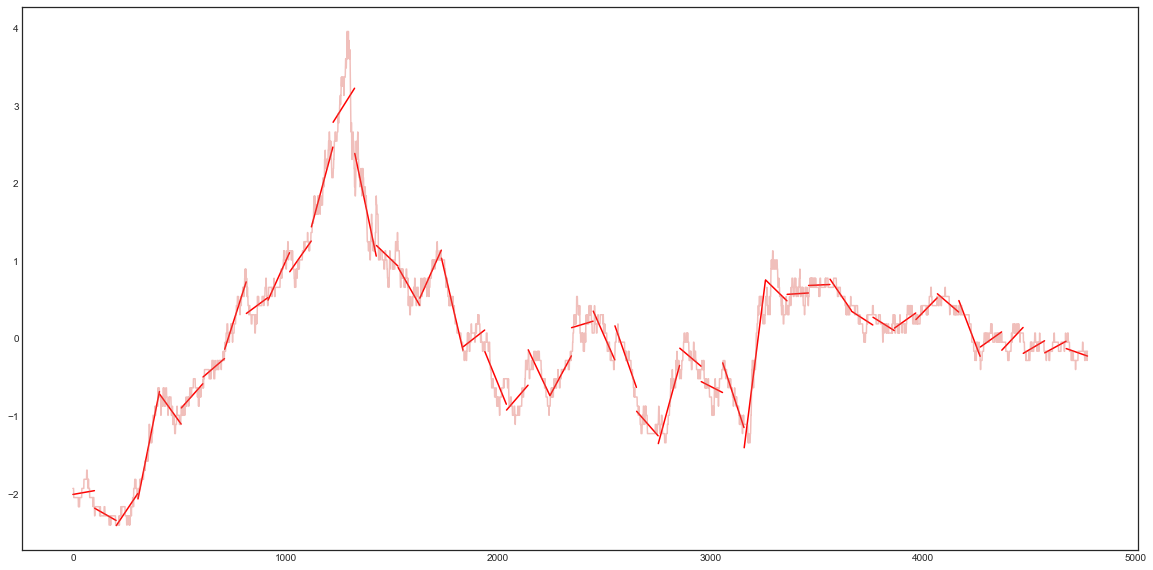

In [14]:
vf.plot_linear_ls(x, df['British/US'].values, window_size=100)

plt.plot(df.index.values, df['British/US'], alpha=0.4)

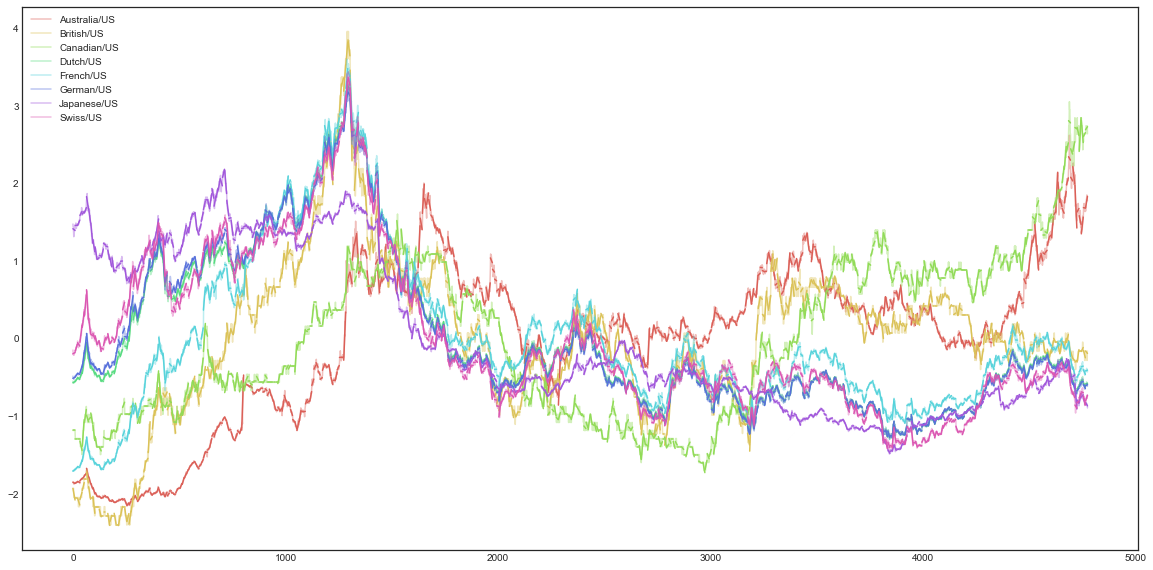

In [15]:
i = 0
x = df.index.values[:, None]
for col in df.columns.values[1:]:
    c=sns.color_palette("hls", 8)[i]
    vf.plot_linear_ls(x, df[col].values, window_size=10, colour=c)
    plt.plot(x, df[col], c=c, label=col, alpha=0.4)
    i += 1
plt.legend()

In [16]:
coefs

array([[-2.01125788e+00,  4.81221369e-04],
       [-2.02962228e+00, -1.56163666e-03],
       [-3.24769576e+00,  4.09104815e-03],
       [-6.26493019e+00,  1.37114765e-02],
       [ 8.37238254e-01, -3.81311281e-03],
       [-2.46710138e+00,  3.08128309e-03],
       [-1.93528756e+00,  2.35011987e-03],
       [-6.28134415e+00,  8.60266511e-03],
       [-1.33145294e+00,  2.02686175e-03],
       [-5.06347240e+00,  6.05459130e-03],
       [-3.13371384e+00,  3.91575560e-03],
       [-9.99206923e+00,  1.01882962e-02],
       [-2.53090453e+00,  4.34565558e-03],
       [ 1.97672919e+01, -1.31082835e-02],
       [ 4.95078606e+00, -2.62738869e-03],
       [ 8.27466892e+00, -4.81021415e-03],
       [-9.48203612e+00,  6.12857408e-03],
       [ 2.13920714e+01, -1.17399352e-02],
       [-4.02288695e+00,  2.13283709e-03],
       [ 1.28387652e+01, -6.71243824e-03],
       [-7.39128479e+00,  3.17059564e-03],
       [ 1.22400448e+01, -5.78265457e-03],
       [-1.21574716e+01,  5.08881600e-03],
       [-1.

In [17]:
np.std(coefs, axis=0)

array([1.52145551e+01, 6.27228698e-03])

In [18]:
n, m = coefs.shape

In [19]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    return mutual_info_score(None, None, contingency=c_xy)

In [ ]:
np.histogram()

In [20]:
db = int(np.floor(n /2))

In [21]:
db

23

In [22]:
calc_MI(coefs[:db, 1], coefs[db:-1, 1], 10)

0.6815747274645075

In [23]:
mi = cos_sim(coefs[:-1, 1].reshape(int(n / 2), 2))

In [24]:
mi.shape

(23, 23)

In [25]:
mi[0,0]

0.9999999999999999

In [26]:
from scipy import spatial

In [27]:
1 - spatial.distance.cosine(coefs[:db, 1], coefs[db:-1, 1])

-0.14159732173018713

In [142]:
exam = df['Australia/US'].values
n = exam.size

In [143]:
n / 2

2387.0

In [144]:
e0, e1 = np.hsplit(exam.reshape(int(n/2), 2), 2)

In [145]:
1 - spatial.distance.cosine(e0, e1)

0.9991544915130832

In [146]:
calc_MI(e0.squeeze(), e1.squeeze(), 10)

1.5708012654890608

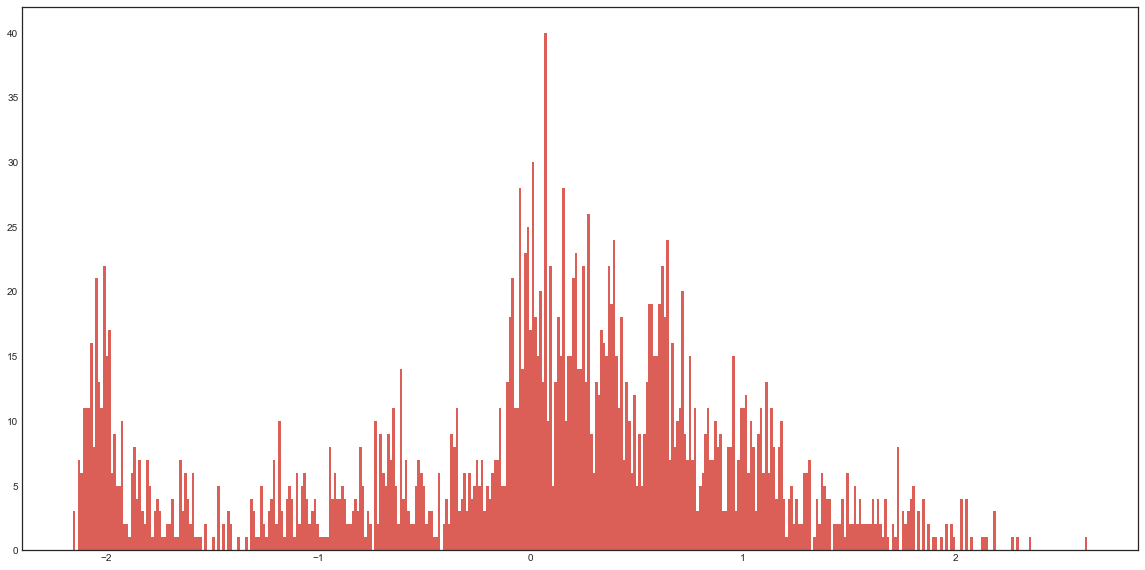

In [153]:
plt.hist(e0.squeeze(), bins=400);

In [148]:
np.histogram(e0.squeeze(), bins='auto')[1].shape

(29,)

In [132]:
e0.shape

(2387, 1)

In [133]:
bincheck = [calc_MI(e0.squeeze(), e1.squeeze(), i) for i in np.arange(1, 2000, 3)]

In [154]:
from numpy.lib import function_base as np_fb

In [166]:
from numpy.lib import function_base as np_fb
int(np.round(np.ptp(e0.squeeze()) / np_fb._hist_bin_auto(e0.squeeze()), 0))

27

In [188]:
from scipy import stats, optimize
from sklearn.metrics import mutual_info_score
import olac.maths as om

In [168]:
om.mutual_info(e0.squeeze(), e1.squeeze())

2.305489867622623

In [182]:
skm.normalized_mutual_info_score(e0.squeeze(), e0.squeeze())

1.0

In [171]:
import sklearn.metrics as skm

In [205]:
e0.squeeze() + np.random.normal(0, 0.5, size=e0.squeeze().shape)

array([-0.85781686, -1.7660039 , -1.5105557 , ...,  1.46060526,
        2.3093387 ,  0.41438959])

In [184]:
np.random.normal(0, 0.1, 1000).sum()

1.1037237801101234

In [185]:
arr = np.random.normal(0, 0.1, 1000)

In [187]:
(arr / arr.sum())

1.0000000000000002

In [230]:
om.KL_div(e0.squeeze(), e0.squeeze() + np.random.normal(1000, 0.5, size=e0.squeeze().shape))

8.589772914593452
8.472723309802872


8.531248112198162

In [200]:
np.isnan((e0.squeeze() / e0.squeeze().sum()) + 0.0001).sum()

0

In [212]:
hi, bins = np.histogram(e0.squeeze(), bins=om.auto_bin(e0.squeeze()))  

In [215]:
np.histogram(e0.squeeze() + np.random.normal(10000, 0.5, size=e0.squeeze().shape), bins=bins)[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [18]:
import sklearn.metrics as sm

In [17]:
pw = smp.pairwise.pairwise_distances(np.random.normal(0, 1, (10000, 2)), metric='euclidean', n_jobs=1).shape

(10000, 10000)

In [19]:
sm.silhouette_score(np.random.normal(0, 1, (10000, 1)))

TypeError: silhouette_score() missing 1 required positional argument: 'labels'

In [62]:
x = np.hstack((np.random.normal(0, 1, (10000, 1)), np.random.normal(0, 5, (10000, 1))))

In [87]:
def sed(arr):
    n, m = arr.shape
    return np.sqrt(((arr - (arr.sum(0) / n)) ** 2).sum(0))
    
    

In [64]:
sed(x)

array([0.00993829, 0.00202179])

In [65]:
x.ndim

2

In [66]:
def sigmoid(arr):
    return 1 / (1 + np.exp(-arr))

In [67]:
sigmoid(sed(x))

array([0.50248455, 0.50050545])

In [73]:
((x - (np.sum(x, 0) / 10000)) ** 2).sum()

254763.61289659547

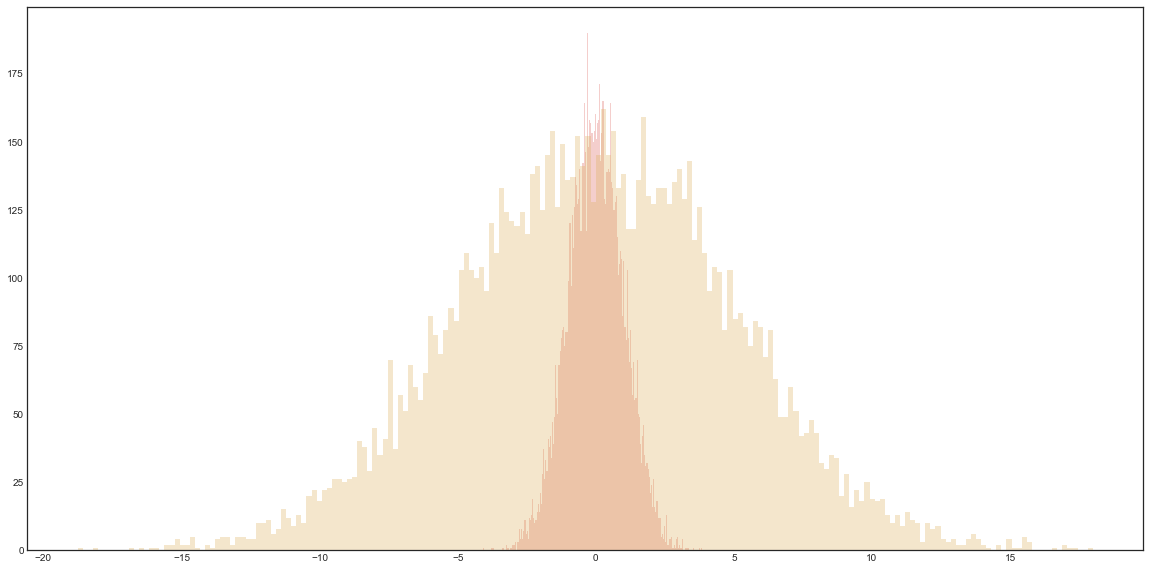

In [88]:
plt.hist(x[:, 0], bins=200, alpha=0.3);
plt.hist(x[:, 1], bins=200, alpha=0.3);

In [89]:
print('\n sigma: 1')
print('var: ', np.var(x[:, 0]))
print('sed: ', sed(x[:, 0][:, None]))

print('\n sigma: 5')
print('var: ', np.var(x[:, 1]))
print('sed: ', sed(x[:, 1][:, None]))


 sigma: 1
var:  1.0124568877860303
sed:  [100.6209167]

 sigma: 5
var:  24.463904401873517
sed:  [494.60999183]


In [92]:
np.abs(np.mean(x, 0)) / np.var(x, 0) 

array([0.00725028, 0.00048956])

In [2]:
aa = np.random.normal(size=100)
np.dot(aa, np.ones_like(aa))

1.433969428498144

In [3]:
aa.sum()

1.4339694284981424